In [2]:
import pandas as pd
import numpy as np
from collections import Counter as ctr

In [92]:
# https://www.geeksforgeeks.org/python-stemming-words-with-nltk/

data = pd.read_csv('pnp-train-2.txt',delimiter='\t',encoding='latin-1', names=['type','name'])
# basic tokenization
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#ps = PorterStemmer()
 
data['clean'] = data.name.apply(lambda x: word_tokenize(x))
#data['clean'] = data.clean.apply(lambda words: [ps.stem(word) for word in words])

### Split into train and test data

In [81]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=200)

# create ctr
type_ctr = ctr(train.type)

### Create Helper Functions for Naive-Based Classifier
$$ΠP(C|w_1,w_2...) = \frac{P(w_i|C)P(C)}{P(w_i)}$$

In [82]:
# P(C) - prior probability
def Pa(C=''):
    return type_ctr[C] / len(train)

In [83]:
# P(w_i) - probablity of word
words_ctr = ctr([word for row in train.clean for word in row])

def Pb(W=''):
    if W not in words_ctr:
        return 0.0001
    return words_ctr[W] / sum(words_ctr.values())

In [84]:
# Get word counts given a type
type_word_count = {}

for col_name in list(set(data.type)):
    sub_df = train[train.type == col_name]
    type_word_count[col_name] = []
    for row in sub_df.clean:
        for word in row:
            type_word_count[col_name].append(word)
    type_word_count[col_name] = ctr(type_word_count[col_name])

# Define P(w_i|C)
def Pba(W='', C=''):
    t = type_word_count[C]
    if W not in t: return 0.0000001
    return t[W] / sum(t.values())

In [85]:
# Define P(C|w1, w2, w3,...,wn)
def Pab(C='', W=''):
    return (Pba(W=W, C=C) * Pa(C=C) / Pb(W=W))

In [86]:
# define P(type|sentence)
def Ps(S, C=''):
    return np.prod([Pab(C=C, W=word) for word in S])

In [87]:
def bayesClassifier(df):
    guesses = []
    for _, row in df.iterrows():
        bestProb = 0
        bestGuess = ''
        for currType in df['type'].unique():
            currProb = Ps(S=row['clean'], C=currType)
            if (currProb > bestProb):
                bestGuess = currType
                bestProb = currProb
        guesses.append(bestGuess)
    return guesses

### Define BaseLines

In [88]:
# sources: 
# https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f/

import numpy as np
import random
X = np.array(test['clean'])
y = np.array(test['type'])

# Most Frequent Baseline
common_tag = type_ctr.most_common(1)[0][0]
most_frequent = sum(y == common_tag) / len(y)
print(f'Most Frequent baseline: {most_frequent}')

# Random Baseline
keys = train['type'].unique()
random_base = sum(y == keys[random.randint(0,4)]) / len(y)
print(f'Random Baseline: {random_base}')

Most Frequent baseline: 0.2894548916924542
Random Baseline: 0.11901928112354201


In [12]:
train['guesses'] = bayesClassifier(train)

In [13]:
sum(train['type'] == train['guesses']) / len(train)

0.992202380952381

In [89]:
test['guesses'] = bayesClassifier(test)

In [90]:
sum(test['type'] == test['guesses']) / len(test)

0.6672220899785766

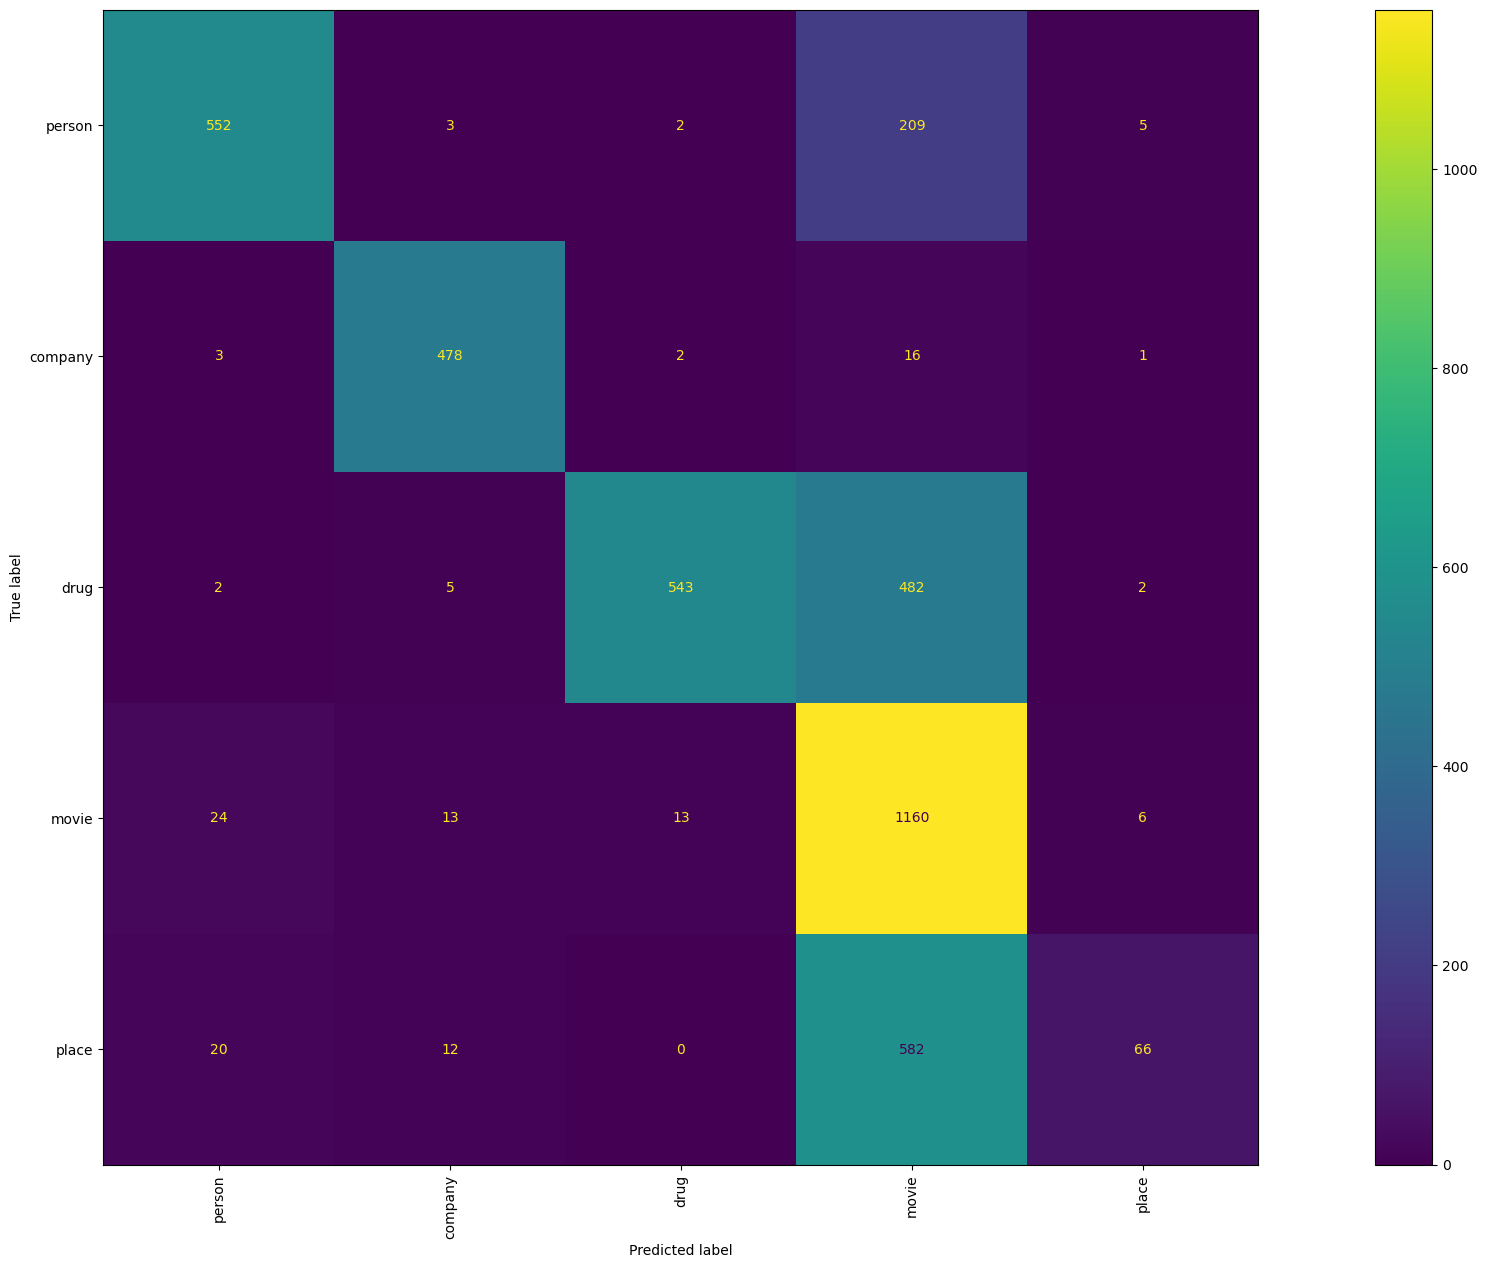

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test['type'], test['guesses'], labels=test['type'].unique())
fig, ax = plt.subplots(figsize=(30, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test['type'].unique())
disp.plot(ax=ax)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()

### Q&A

#### What are the two baselines for this particular task? How did you determine the two baselines?
The two baselines I used for this task were the most frequent baseline and uniform (random) baseline.  I chose the frequent baseline because it gave me an idea of how well the classifier would perform if it just picked the most common tag.  I then chose the uniform baseline because it allowed me to see how the model performed if it chose a tag at random.
#### What is the accuracy of your classifier?
My classifier is 66.6% accurate when testing against the test data and 99.1% accurate when testing against the training data.
#### What kind of normalization did you apply? Why does it make sense to do that for this particular task? How does your accuracy change if you don’t apply that normalization strategy?
I used tokenization.  Tokenization made sense because it was essential to get the probablility of each individual word.  In order to even get close to an accurate score, this had to be implemented.  Without using tokenization, the accuracy of the program is only around 25-30%.  The other types of normalization don't have a huge effect on the probability, in fact, removing stop words and adding stemming made the accurracy go down a small amount.
#### What modeling approach did you use? I.e., how did you model the probability of a name (a sequence of words)?
I used the naive-bayes classification approach.  I needed to get the probability of a word, then the probability of the type, then the probability of a word given a type in order to build the classifier.  After all of those functions were built, I needed to loop through the sequence of words and multiply their probabilities with each other.  Then, I put a loop over this entire process and took the best type probability.
#### What assumptions does your model make?
My model assumes that all of the words do not depend on any other words around them.  This is obviously not the case, but this is what makes it a *naive* bayes classifier.
#### Create a confusion matrix of your model’s predictions/guesses vs. the real types. What do you notice?
I noticed that there was a lot of confusion in my model in predicting movie for place and drug.  I would guess this is because 'movie' is the most common type at around 30%, but its still interesting to see how bad it performed.  Other than that type, the rest of the tags were much better in terms of performance at very low incorrect guesses.